## Downloading the Dataset

In [ ]:
!wget https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar
!tar -xf abo-images-small.tar
!rm abo-images-small.tar
!gunzip images/metadata/images.csv.gz

In [ ]:
!wget https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-listings.tar
!tar -xvf abo-listings.tar
!rm abo-listings.tar

In [3]:
# Size of the dataset
!find images/small -type f -iname "*.jpg" | wc -l

398210


In [4]:
import os
import cv2
import json
import gzip
import time
import random

from google.colab.patches import cv2_imshow
from google import genai

In [ ]:
with open("images/metadata/images.csv", "r") as f:
    lines = [line.strip("\n").split(",") for line in f.readlines()]

path_to_id = {line[-1] : line[0] for line in lines}

In [7]:
with gzip.open('listings/metadata/listings_f.json.gz', 'rt', encoding='utf-8') as f:
    metadata = [json.loads(line) for line in f]

cleaned_metadata = {
    product["main_image_id"] : {
        "product_name" : product["item_name"][0]["value"],
        "features" : [item['value'] for item in product.get('bullet_point', [])],
        "tags" : [item['value'] for item in product.get('item_keywords', [])[:10]],
    } for product in metadata if "main_image_id" in product
}

cleaned_metadata[list(cleaned_metadata.keys())[0]]

{'product_name': 'Amazon Brand - Solimo Designer Couples Sitting at Dark 3D Printed Hard Back Case Mobile Cover for Lenovo K4 Note',
 'features': ['3D Printed Hard Back Case Mobile Cover for Lenovo K4 Note',
  'Easy to put & take off with perfect cutouts for volume buttons, audio & charging ports.',
  'Stylish design and appearance, express your unique personality.',
  'Extreme precision design allows easy access to all buttons and ports while featuring raised bezel to life screen and camera off flat surface.',
  'Slim Hard Back Cover',
  'No Warranty',
  'None'],
 'tags': ['mobile cover',
  'back cover',
  'mobile case',
  'phone case',
  'mobile panel',
  'phone panel',
  'Lenovo mobile case',
  'Lenovo phone cover',
  'Lenovo back case',
  'hard case']}

In [8]:
print("Invalid rows: ", len(metadata) - len(cleaned_metadata), "/", len(metadata), sep="")

Invalid rows: 305/9222


## Testing Inference on Gemini

In [9]:
GEMINI_API_KEY = "<insert-api-key>"

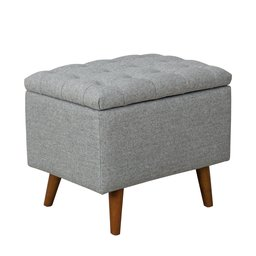

In [10]:
img = cv2.imread("images/small/ec/ec8e1726.jpg")
cv2_imshow(img)

In [11]:
prompt_intro = '''
Given a product image, generate a set of diverse questions that can be answered solely by looking at the image.
Each question must have a single-word answer (e.g., "red", "shoes", "five", "yes").
Cover a range of question types, including:

- Object recognition (e.g., What product is shown?)
- Attribute detection (e.g., What color is the product?)
- Material/texture recognition (e.g., What material is the product made of?)
- Size/shape recognition (e.g., What is the shape of the product?)
- Brand recognition (e.g., What brand is the product?)
- Counting (e.g., How many items are in the image?)
- Yes/No questions (e.g., Is the product a smartphone?)

Mix easy and challenging questions. Avoid subjective or ambiguous questions.

Use this product information for reference but only generate questions that can be answered from the image alone.

Product Information:
'''

prompt_outro = '''
Output Format:
For each product image, return a list of 3-4 questions and their single-word answers. Respond in this format (do not include any extra information):

[
    {
        "question": "What product is shown?",
        "answer": "Laptop"
    },
    {
        "question": "What color is the product?",
        "answer": "Black"
    },
    {
        "question": "Is the logo visible?",
        "answer": "Yes"
    },
    {
        "question": "What material is the product made of?",
        "answer": "Plastic"
    },
    {
        "question": "Is the product in a box?",
        "answer": "No"
    }
]
'''

In [12]:
def extract_json(output):
    try:
        start = output.find('[')
        end = output.rfind(']')
        json_str = output[start:end+1]

        data = json.loads(json_str)

        # Check format
        if not isinstance(data, list):
            raise ValueError("The response should be a list of Q&A pairs.")
        for item in data:
            if not isinstance(item, dict):
                raise ValueError("Each item in the list should be a dictionary.")
            if "question" not in item or "answer" not in item:
                raise ValueError("Each dictionary should contain 'question' and 'answer' keys.")
            if not isinstance(item["question"], str) or not isinstance(item["answer"], str):
                raise ValueError("Both 'question' and 'answer' should be strings.")

        return data

    except:
        return None

In [13]:
%cd images/small

/content/images/small


## Dataset Generation

In [15]:
api_keys = [
    "<insert-api-key>",
    "<insert-api-key>",
    "<insert-api-key>",
    "<insert-api-key>",
    "<insert-api-key>"
]

clients = [genai.Client(api_key=key) for key in api_keys]

dataset = {}
dir = "fe"
client_index = 0
total_keys = len(clients)

def get_next_client(start_index):
    for i in range(total_keys):
        yield (start_index + i) % total_keys

# Iterates through the API keys in a round robin fashion to avoid hitting rate limits
try:
    for request_count, img in enumerate(os.listdir(dir)[:100], 1):
        path = f"{dir}/{img}"
        print(f"Image {request_count}/100")

        for idx in get_next_client(client_index):
            client = clients[idx]
            try:
                file = client.files.upload(file=path)
                response = client.models.generate_content(
                    model="gemini-2.0-flash",
                    contents=[
                        file,
                        prompt_intro + str(cleaned_metadata.get(path_to_id[path], "")) + prompt_outro
                    ]
                )
                client.files.delete(name=file.name)

                json_qa = extract_json(response.text)
                print(json_qa)

                if json_qa is not None:
                    dataset[f"images/small/{dir}/{img}"] = json_qa
                else:
                    print(f"images/small/{dir}/{img} skipped")

                client_index = (idx + 1) % total_keys
                break

            except Exception as e:
                print(f"Client {idx} failed: {e}")
                continue
        else:
            print(f"All clients failed for {img}, skipping.")
            break

finally:
    with open(f"/content/dataset_{dir}.json", "w") as f:
        json.dump(dataset, f, indent=4)

Image 1/100
[{'question': 'What food is pictured?', 'answer': 'Pistachios'}, {'question': "What is the container's shape?", 'answer': 'Square'}, {'question': 'Are ingredients listed?', 'answer': 'Yes'}, {'question': 'Is barcode visible?', 'answer': 'Yes'}]
Image 2/100
[{'question': 'What are these?', 'answer': 'Strings'}, {'question': 'What shape are they?', 'answer': 'Circular'}, {'question': 'How many are pictured?', 'answer': 'Six'}, {'question': 'Are these coiled?', 'answer': 'Yes'}]
Image 3/100
[{'question': 'What food is shown?', 'answer': 'Macarons'}, {'question': 'Are there green macarons?', 'answer': 'Yes'}, {'question': 'How are they arranged?', 'answer': 'Vertically'}, {'question': 'Is it a phone?', 'answer': 'Yes'}]
Image 4/100
[{'question': 'What shape is this?', 'answer': 'Square'}, {'question': 'What color is it?', 'answer': 'White'}, {'question': 'Is texture visible?', 'answer': 'Yes'}]
Image 5/100
[{'question': 'What product is shown?', 'answer': 'Trimmer'}, {'question

In [16]:
with open(f"/content/dataset_{dir}.json", "r") as f:
    dataset = json.load(f)

dataset

{'images/small/fe/fe108332.jpg': [{'question': 'What food is pictured?',
   'answer': 'Pistachios'},
  {'question': "What is the container's shape?", 'answer': 'Square'},
  {'question': 'Are ingredients listed?', 'answer': 'Yes'},
  {'question': 'Is barcode visible?', 'answer': 'Yes'}],
 'images/small/fe/feff9d03.jpg': [{'question': 'What are these?',
   'answer': 'Strings'},
  {'question': 'What shape are they?', 'answer': 'Circular'},
  {'question': 'How many are pictured?', 'answer': 'Six'},
  {'question': 'Are these coiled?', 'answer': 'Yes'}],
 'images/small/fe/fe8f7675.jpg': [{'question': 'What food is shown?',
   'answer': 'Macarons'},
  {'question': 'Are there green macarons?', 'answer': 'Yes'},
  {'question': 'How are they arranged?', 'answer': 'Vertically'},
  {'question': 'Is it a phone?', 'answer': 'Yes'}],
 'images/small/fe/fe6e00b4.jpg': [{'question': 'What shape is this?',
   'answer': 'Square'},
  {'question': 'What color is it?', 'answer': 'White'},
  {'question': 'Is 

In [18]:
%cd /content

/content


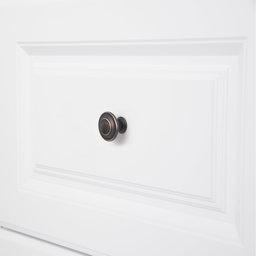

[{'question': 'What color is the surface?', 'answer': 'White'},
 {'question': 'What shape is the knob?', 'answer': 'Round'},
 {'question': 'Is there a knob?', 'answer': 'Yes'},
 {'question': 'What material is the drawer?', 'answer': 'Wood'}]

In [20]:
sample_image_path = random.choice(list(dataset.keys()))

img = cv2.imread(sample_image_path)
cv2_imshow(img)
dataset[sample_image_path]